# Regresión Lineal

## Preparación de ambiente

### Carga de módulos

In [ ]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data Viz
import plotly.express as px
#import cufflinks as cf

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Enviroment setup
# cf.go_offline()
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


### Funciones auxiliares

In [ ]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

In [ ]:
def normalize_content(texto):
    if texto in ['G', 'TV-G']:
        return "Publico General"
    if texto in ['R', 'NC-17', 'X']:
        return "Restricted"
    if texto in ['M', 'PG', 'GP', 'PG-13', 'TV-PG', 'TV-14'] :
        return "Parental Guiadance"
    if texto in ['Approved', 'Passed']:
        return "Approved"
    if texto in ['Not Rated', 'Unrated']:
        return "Not Rated"

In [ ]:
def normalize(df, features):
    for feature in features:
        aux = df[feature].value_counts(True)
        ls_categories = [category for category, freq in aux.items() if freq > 0.05]
        df[feature] = df[feature].map(lambda x: x if x in ls_categories else "Others")
    return df

## Data Wrangling

### Lectura de datos

In [ ]:
df = pd.read_csv("movies.csv")

In [ ]:
df.sample(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1192,Color,Joel Schumacher,71.0000,149.0000,541.0000,1000.0000,Matthew McConaughey,18000.0000,108706165.0000,Crime|Drama|Thriller,Kevin Spacey,A Time to Kill,99558,31349,Oliver Platt,3.0000,african american|court|law|mississippi|trial,http://www.imdb.com/title/tt0117913/?ref_=fn_t...,236.0000,English,USA,R,40000000.0000,1996.0000,11000.0000,7.4000,2.3500,0
1377,Color,Charles Martin Smith,131.0000,113.0000,188.0000,631.0000,Michael Roark,11000.0000,72279690.0000,Drama|Family,Morgan Freeman,Dolphin Tale,17948,14209,Harry Connick Jr.,5.0000,boy|dolphin|prosthetics|tail|trap,http://www.imdb.com/title/tt1564349/?ref_=fn_t...,86.0000,English,USA,PG,37000000.0000,2011.0000,680.0000,6.9000,1.8500,0
254,Color,Steven Soderbergh,198.0000,125.0000,0.0000,350.0000,Julia Roberts,11000.0000,125531634.0000,Crime|Thriller,Brad Pitt,Ocean's Twelve,284852,19359,Mini Anden,0.0000,father daughter relationship|heist|pretending ...,http://www.imdb.com/title/tt0349903/?ref_=fn_t...,627.0000,English,USA,PG-13,110000000.0000,2004.0000,8000.0000,6.4000,2.3500,0
3409,Color,John Carney,283.0000,104.0000,109.0000,7.0000,Karen Pittman,480.0000,16168741.0000,Drama|Music,James Corden,Begin Again,99430,517,Mary Catherine Garrison,1.0000,manhattan new york city|new york city|record l...,http://www.imdb.com/title/tt1980929/?ref_=fn_t...,182.0000,English,USA,R,8000000.0000,2013.0000,12.0000,7.4000,1.8500,43000
4595,Color,Nick Tomnay,112.0000,93.0000,11.0000,271.0000,Clayne Crawford,443.0000,48430.0000,Comedy|Crime|Thriller,David Hyde Pierce,The Perfect Host,20176,1452,Nathaniel Parker,1.0000,arm tattoo|bank robbery|cauterizing a wound|da...,http://www.imdb.com/title/tt1334553/?ref_=fn_t...,73.0000,English,USA,R,500000.0000,2010.0000,298.0000,6.8000,1.8500,0


### EDA

In [ ]:
# Haz una histograma dinámico de la variable facenumber_in_poster
fig = px.histogram(df.reset_index(), x="facenumber_in_poster", nbins=30, title="Histogram of facenumber_in_poster")
fig.update_layout(xaxis_title="facenumber_in_poster", yaxis_title="Count")
fig.show()

#### Filtrado de variables

In [ ]:
ls_cont = ["num_critic_for_reviews", "duration", "director_facebook_likes", "actor_3_facebook_likes", "gross", "actor_1_facebook_likes", "facenumber_in_poster", "num_user_for_reviews", "budget", "title_year", "actor_2_facebook_likes", "movie_facebook_likes", "aspect_ratio"]
ls_disc = ["color", "genres", "plot_keywords", "language", "country", "content_rating"]
ls_drop = ["director_name", "actor_2_name", "actor_1_name", "actor_3_name", "movie_imdb_link"]
ls_indx = ["movie_title"]
target = "imdb_score"

#### Coerción de tipo de dato

In [ ]:
df = df.set_index(ls_indx)

In [ ]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,James Cameron,723.0000,178.0000,0.0000,855.0000,Joel David Moore,1000.0000,760505847.0000,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,886204,4834,Wes Studi,0.0000,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0000,English,USA,PG-13,237000000.0000,2009.0000,936.0000,7.9000,1.7800,33000
Pirates of the Caribbean: At World's End,Color,Gore Verbinski,302.0000,169.0000,563.0000,1000.0000,Orlando Bloom,40000.0000,309404152.0000,Action|Adventure|Fantasy,Johnny Depp,471220,48350,Jack Davenport,0.0000,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0000,English,USA,PG-13,300000000.0000,2007.0000,5000.0000,7.1000,2.3500,0
Spectre,Color,Sam Mendes,602.0000,148.0000,0.0000,161.0000,Rory Kinnear,11000.0000,200074175.0000,Action|Adventure|Thriller,Christoph Waltz,275868,11700,Stephanie Sigman,1.0000,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0000,English,UK,PG-13,245000000.0000,2015.0000,393.0000,6.8000,2.3500,85000
The Dark Knight Rises,Color,Christopher Nolan,813.0000,164.0000,22000.0000,23000.0000,Christian Bale,27000.0000,448130642.0000,Action|Thriller,Tom Hardy,1144337,106759,Joseph Gordon-Levitt,0.0000,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0000,English,USA,PG-13,250000000.0000,2012.0000,23000.0000,8.5000,2.3500,164000
Star Wars: Episode VII - The Force Awakens,NaN,Doug Walker,NaN,NaN,131.0000,NaN,Rob Walker,131.0000,NaN,Documentary,Doug Walker,8,143,NaN,0.0000,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0000,7.1000,NaN,0


In [ ]:
df[ls_cont] = df[ls_cont].astype(float)

In [ ]:
df[target] = df[target].astype(float)

In [ ]:
df[ls_disc] = df[ls_disc].fillna("").astype(str)

In [ ]:
df.drop(columns=ls_drop, inplace=True)

#### EDA discretas

#### EDA continuas

In [ ]:
for col in ls_cont:
    fig = px.histogram(df.reset_index(), x=col, title=col)
    fig.show()

In [ ]:
fig = px.histogram(df.reset_index(), x=target, title=target)
fig.show()

### Feature Engineering

#### Género

In [ ]:
df["genres"] = df["genres"].str.replace("|", " ").str.replace("-", "").str.lower()

In [ ]:
df["genres"]

movie_title
Avatar                                                     action adventure fantasy scifi
Pirates of the Caribbean: At World's End                         action adventure fantasy
Spectre                                                         action adventure thriller
The Dark Knight Rises                                                     action thriller
Star Wars: Episode VII - The Force Awakens                                    documentary
                                                                        ...              
Signed Sealed Delivered                                                      comedy drama
The Following                                                crime drama mystery thriller
A Plague So Pleasant                                                drama horror thriller
Shanghai Calling                                                     comedy drama romance
My Date with Drew                                                             documentar

In [ ]:
vect = CountVectorizer(ngram_range=(1, 1), max_features=10)

In [ ]:
vect.fit(df["genres"])

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [ ]:
df_genres = pd.DataFrame(data=vect.transform(df["genres"]).todense(), 
                         columns=[f"genre_{x}" for x in vect.get_feature_names_out()],
                         index=df.index)

In [ ]:
df_genres.head()

,genre_action,genre_adventure,genre_comedy,genre_crime,genre_drama,genre_fantasy,genre_horror,genre_romance,genre_scifi,genre_thriller
movie_title,,,,,,,,,,
Avatar,1,1,0,0,0,1,0,0,1,0
Pirates of the Caribbean: At World's End,1,1,0,0,0,1,0,0,0,0
Spectre,1,1,0,0,0,0,0,0,0,1
The Dark Knight Rises,1,0,0,0,0,0,0,0,0,1
Star Wars: Episode VII - The Force Awakens,0,0,0,0,0,0,0,0,0,0


In [ ]:
ls_disc.remove("genres")

In [ ]:
ls_cont += df_genres.columns.tolist()

#### Keywords

In [ ]:
df["plot_keywords"] = df["plot_keywords"].str.replace("|", " ").str.replace("-", "").str.lower()

In [ ]:
vect = CountVectorizer(ngram_range=(1, 1), max_features=10)

In [ ]:
vect.fit(df["plot_keywords"])

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [ ]:
df_kw = pd.DataFrame(data=vect.transform(df["plot_keywords"]).todense(), 
                     columns=[f"kw_{x}" for x in vect.get_feature_names_out()],
                     index=df.index)

In [ ]:
df_kw

,kw_female,kw_friend,kw_in,kw_love,kw_nudity,kw_of,kw_on,kw_school,kw_the,kw_title
movie_title,,,,,,,,,,
Avatar,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,0,0,0,0,0,0,0,0,0,0
Spectre,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,0,0,0,0,0,0,0,0,0,0
Star Wars: Episode VII - The Force Awakens,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Signed Sealed Delivered,0,0,0,0,0,0,0,0,0,0
The Following,0,0,0,0,0,0,0,0,0,0
A Plague So Pleasant,0,0,0,0,0,0,0,0,0,0


In [ ]:
ls_disc.remove("plot_keywords")

In [ ]:
ls_cont += df_kw.columns.tolist()

#### Likes

In [ ]:
ls_likes = ['actor_3_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes']

In [ ]:
df["avg_fb_likes"] = df[ls_likes].mean(axis=1)

In [ ]:
df

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,avg_fb_likes
movie_title,,,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,723.0000,178.0000,0.0000,855.0000,1000.0000,760505847.0000,action adventure fantasy scifi,886204,4834,0.0000,avatar future marine native paraplegic,3054.0000,English,USA,PG-13,237000000.0000,2009.0000,936.0000,7.9000,1.7800,33000.0000,930.3333
Pirates of the Caribbean: At World's End,Color,302.0000,169.0000,563.0000,1000.0000,40000.0000,309404152.0000,action adventure fantasy,471220,48350,0.0000,goddess marriage ceremony marriage proposal pi...,1238.0000,English,USA,PG-13,300000000.0000,2007.0000,5000.0000,7.1000,2.3500,0.0000,15333.3333
Spectre,Color,602.0000,148.0000,0.0000,161.0000,11000.0000,200074175.0000,action adventure thriller,275868,11700,1.0000,bomb espionage sequel spy terrorist,994.0000,English,UK,PG-13,245000000.0000,2015.0000,393.0000,6.8000,2.3500,85000.0000,3851.3333
The Dark Knight Rises,Color,813.0000,164.0000,22000.0000,23000.0000,27000.0000,448130642.0000,action thriller,1144337,106759,0.0000,deception imprisonment lawlessness police offi...,2701.0000,English,USA,PG-13,250000000.0000,2012.0000,23000.0000,8.5000,2.3500,164000.0000,24333.3333
Star Wars: Episode VII - The Force Awakens,,NaN,NaN,131.0000,NaN,131.0000,NaN,documentary,8,143,0.0000,,NaN,,,,NaN,NaN,12.0000,7.1000,NaN,0.0000,71.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Signed Sealed Delivered,Color,1.0000,87.0000,2.0000,318.0000,637.0000,NaN,comedy drama,629,2283,2.0000,fraud postal worker prison theft trial,6.0000,English,Canada,,NaN,2013.0000,470.0000,7.7000,NaN,84.0000,475.0000
The Following,Color,43.0000,43.0000,NaN,319.0000,841.0000,NaN,crime drama mystery thriller,73839,1753,1.0000,cult fbi hideout prison escape serial killer,359.0000,English,USA,TV-14,NaN,NaN,593.0000,7.5000,16.0000,32000.0000,584.3333
A Plague So Pleasant,Color,13.0000,76.0000,0.0000,0.0000,0.0000,NaN,drama horror thriller,38,0,0.0000,,3.0000,English,USA,,1400.0000,2013.0000,0.0000,6.3000,NaN,16.0000,0.0000


In [ ]:
ls_cont = [x for x in ls_cont if x not in ls_likes] + ["avg_fb_likes"]

In [ ]:
df.drop(columns=ls_likes + ["genres", "plot_keywords"], inplace=True)

In [ ]:
df = pd.concat([df, df_kw, df_genres], axis=1)

In [ ]:
df.head(5)

,color,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,imdb_score,aspect_ratio,movie_facebook_likes,avg_fb_likes,kw_female,kw_friend,kw_in,kw_love,kw_nudity,kw_of,kw_on,kw_school,kw_the,kw_title,genre_action,genre_adventure,genre_comedy,genre_crime,genre_drama,genre_fantasy,genre_horror,genre_romance,genre_scifi,genre_thriller
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,723.0000,178.0000,0.0000,760505847.0000,886204,4834,0.0000,3054.0000,English,USA,PG-13,237000000.0000,2009.0000,7.9000,1.7800,33000.0000,930.3333,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
Pirates of the Caribbean: At World's End,Color,302.0000,169.0000,563.0000,309404152.0000,471220,48350,0.0000,1238.0000,English,USA,PG-13,300000000.0000,2007.0000,7.1000,2.3500,0.0000,15333.3333,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
Spectre,Color,602.0000,148.0000,0.0000,200074175.0000,275868,11700,1.0000,994.0000,English,UK,PG-13,245000000.0000,2015.0000,6.8000,2.3500,85000.0000,3851.3333,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
The Dark Knight Rises,Color,813.0000,164.0000,22000.0000,448130642.0000,1144337,106759,0.0000,2701.0000,English,USA,PG-13,250000000.0000,2012.0000,8.5000,2.3500,164000.0000,24333.3333,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
Star Wars: Episode VII - The Force Awakens,,NaN,NaN,131.0000,NaN,8,143,0.0000,NaN,,,,NaN,NaN,7.1000,NaN,0.0000,71.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Variables dummy

##### Normalización

In [ ]:
df["content_rating"] = df["content_rating"].map(normalize_content).fillna("Not Rated")

In [ ]:
df["content_rating"].value_counts(True)

content_rating
Parental Guiadance   0.4394
Restricted           0.4240
Not Rated            0.0997
Publico General      0.0242
Approved             0.0127
Name: proportion, dtype: float64

In [ ]:
df = normalize(df, [x for x in ls_disc])

In [ ]:
freq_discrete(df, ls_disc)

Feature: color


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
color,,,,
Color,"4,815",95.48%,"4,815",95.48%
Others,228,4.52%,"5,043",100.00%


Feature: language


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
language,,,,
English,"4,704",93.28%,"4,704",93.28%
Others,339,6.72%,"5,043",100.00%


Feature: country


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
country,,,,
USA,"3,807",75.49%,"3,807",75.49%
Others,788,15.63%,"4,595",91.12%
UK,448,8.88%,"5,043",100.00%


Feature: content_rating


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
content_rating,,,,
Parental Guiadance,"2,216",43.94%,"2,216",43.94%
Restricted,"2,138",42.40%,"4,354",86.34%
Not Rated,503,9.97%,"4,857",96.31%
Others,186,3.69%,"5,043",100.00%


In [ ]:
df_dummies = pd.get_dummies(df[ls_disc])

In [ ]:
df = df.drop(columns=ls_disc).join(df_dummies)

In [ ]:
df.shape

(5309, 45)

### Data Cleaning

#### Remoción de outliers

In [ ]:
df[ls_cont].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,num_critic_for_reviews,duration,director_facebook_likes,gross,facenumber_in_poster,num_user_for_reviews,budget,title_year,movie_facebook_likes,aspect_ratio,genre_action,genre_adventure,genre_comedy,genre_crime,genre_drama,genre_fantasy,genre_horror,genre_romance,genre_scifi,genre_thriller,kw_female,kw_friend,kw_in,kw_love,kw_nudity,kw_of,kw_on,kw_school,kw_the,kw_title,avg_fb_likes
count,5257.0000,5294.0000,5201.0000,4380.0000,5296.0000,5288.0000,4800.0000,5197.0000,5309.0000,4974.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5309.0000,5302.0000
mean,144.4820,107.4515,677.0579,50163996.0984,1.3612,283.5425,43277689.7229,2002.5274,7877.5434,2.2172,0.2332,0.1887,0.3622,0.1756,0.5125,0.1258,0.1168,0.2177,0.1251,0.2848,0.0582,0.0437,0.0669,0.0494,0.0499,0.0445,0.0456,0.0478,0.0414,0.0567,3026.4792
std,124.0681,25.0804,2773.4263,70473358.6686,1.9932,389.9172,267168839.3242,12.5163,19517.5561,1.3499,0.4229,0.3913,0.4807,0.3805,0.4999,0.3317,0.3212,0.4128,0.3308,0.4514,0.2707,0.2178,0.2980,0.2268,0.2988,0.2142,0.2251,0.2439,0.2183,0.2853,5872.0843
min,1.0000,7.0000,0.0000,162.0000,0.0000,1.0000,218.0000,1916.0000,0.0000,1.1800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1%,2.0000,44.0000,0.0000,9103.3800,0.0000,1.0000,60000.0000,1952.0000,0.0000,1.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
5%,9.0000,81.0000,0.0000,100668.5000,0.0000,10.0000,500000.0000,1978.0000,0.0000,1.7765,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,56.3333
50%,113.0000,104.0000,50.0000,26652085.5000,1.0000,162.0000,20000000.0000,2005.0000,181.0000,2.3500,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,740.5000
95%,393.0000,146.0000,964.0000,184039998.8000,5.0000,962.0000,135000000.0000,2015.0000,42000.0000,2.3500,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12155.7333
99%,550.3200,192.0700,16000.0000,336530303.0000,8.0000,2067.7800,209010000.0000,2016.0000,95920.0000,4.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,19426.3933
max,813.0000,511.0000,23000.0000,760505847.0000,43.0000,5060.0000,12215500000.0000,2016.0000,349000.0000,16.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0000,2.0000,3.0000,3.0000,5.0000,3.0000,3.0000,3.0000,3.0000,5.0000,218333.3333


In [ ]:
old_shape = df.shape

In [ ]:
ls_ol = ["duration", "director_facebook_likes", "gross", "facenumber_in_poster", 
         "num_user_for_reviews", "budget", "movie_facebook_likes", "aspect_ratio", 
         "avg_fb_likes"]

In [ ]:
dc_perc = {feature: df[feature].quantile(0.99) for feature in ls_ol}

In [ ]:
dc_perc

{'duration': np.float64(192.0699999999997),
 'director_facebook_likes': np.float64(16000.0),
 'gross': np.float64(336530303.0),
 'facenumber_in_poster': np.float64(8.0),
 'num_user_for_reviews': np.float64(2067.7800000000007),
 'budget': np.float64(209010000.0000002),
 'movie_facebook_likes': np.float64(95920.00000000007),
 'aspect_ratio': np.float64(4.0),
 'avg_fb_likes': np.float64(19426.39333333331)}

In [ ]:
for feat, perc in dc_perc.items():
    df = df[(df[feat] <= perc) | (df[feat].isna())]

In [ ]:
df.shape[0] / old_shape[0]

0.9308721039743831

#### Variables altamente vacías

In [ ]:
df.isna().mean()

num_critic_for_reviews              0.0101
duration                            0.0024
director_facebook_likes             0.0144
gross                               0.1748
num_voted_users                     0.0000
cast_total_facebook_likes           0.0000
facenumber_in_poster                0.0022
num_user_for_reviews                0.0042
budget                              0.0943
title_year                          0.0152
imdb_score                          0.0000
aspect_ratio                        0.0650
movie_facebook_likes                0.0000
avg_fb_likes                        0.0014
kw_female                           0.0000
kw_friend                           0.0000
kw_in                               0.0000
kw_love                             0.0000
kw_nudity                           0.0000
kw_of                               0.0000
kw_on                               0.0000
kw_school                           0.0000
kw_the                              0.0000
kw_title   

In [ ]:
ls_missing = [x for x, y in df.isna().mean().items() if y > 0.3]

In [ ]:
ls_missing

[]

#### Variables unarias

In [ ]:
df.nunique()

num_critic_for_reviews                481
duration                              151
director_facebook_likes               427
gross                                3770
num_voted_users                      4498
cast_total_facebook_likes            3723
facenumber_in_poster                    9
num_user_for_reviews                  845
budget                                403
title_year                             91
imdb_score                             76
aspect_ratio                           19
movie_facebook_likes                  824
avg_fb_likes                         3292
kw_female                               5
kw_friend                               3
kw_in                                   4
kw_love                                 4
kw_nudity                               5
kw_of                                   4
kw_on                                   4
kw_school                               4
kw_the                                  4
kw_title                          

In [ ]:
df.std()

num_critic_for_reviews                   110.9679
duration                                  19.8621
director_facebook_likes                 2093.5396
gross                               53549815.9188
num_voted_users                       104807.7424
cast_total_facebook_likes              11448.1515
facenumber_in_poster                       1.5990
num_user_for_reviews                     276.2801
budget                              36669193.3551
title_year                                12.5221
imdb_score                                 1.1035
aspect_ratio                               0.2983
movie_facebook_likes                   13555.8511
avg_fb_likes                            3655.0449
kw_female                                  0.2720
kw_friend                                  0.2200
kw_in                                      0.2996
kw_love                                    0.2304
kw_nudity                                  0.2949
kw_of                                      0.2122


#### Imputación de variables

In [ ]:
im = SimpleImputer(strategy="median")

In [ ]:
df[[x for x in df.columns if x!=target]] = im.fit_transform(df[[x for x in df.columns if x!=target]])

In [ ]:
df.isna().sum()

num_critic_for_reviews               0
duration                             0
director_facebook_likes              0
gross                                0
num_voted_users                      0
cast_total_facebook_likes            0
facenumber_in_poster                 0
num_user_for_reviews                 0
budget                               0
title_year                           0
imdb_score                           0
aspect_ratio                         0
movie_facebook_likes                 0
avg_fb_likes                         0
kw_female                            0
kw_friend                            0
kw_in                                0
kw_love                              0
kw_nudity                            0
kw_of                                0
kw_on                                0
kw_school                            0
kw_the                               0
kw_title                             0
genre_action                         0
genre_adventure          

#### Separación de sets

In [ ]:
X = df[[x for x in df.columns if x!=target]]
y = df[target]

In [ ]:
X.shape

(4942, 44)

### Selección de variables

In [ ]:
kb = SelectKBest(k="all", score_func=f_regression)

In [ ]:
kb.fit(X, y)

,score_func,<function f_r...0013BECE92770>
,k,'all'


In [ ]:
df_scores = pd.DataFrame(data=zip(X.columns, kb.scores_), columns=["feature", "score"]).set_index("feature").sort_values(by="score", ascending=False)

In [ ]:
df_scores

,score
feature,
num_voted_users,885.7955
genre_drama,426.3022
num_critic_for_reviews,400.5321
num_user_for_reviews,367.0574
duration,296.8814
title_year,240.1408
movie_facebook_likes,216.7588
genre_horror,140.6945
language_Others,119.7424


In [ ]:
fig = px.bar(df_scores.reset_index().rename(columns={"index": "feature"}), x="feature", y="score", title="Feature scores")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [ ]:
ls_best = [x for x in df_scores.head(25).index if x not in ["num_voted_users", "num_critic_for_reviews", "num_user_for_reviews", "movie_facebook_likes", "title_year", "gross"]]

In [ ]:
len(ls_best)

19

In [ ]:
ls_best

['genre_drama',
 'duration',
 'genre_horror',
 'language_Others',
 'language_English',
 'genre_comedy',
 'content_rating_Parental Guiadance',
 'color_Others',
 'color_Color',
 'country_USA',
 'director_facebook_likes',
 'country_UK',
 'genre_action',
 'avg_fb_likes',
 'cast_total_facebook_likes',
 'genre_scifi',
 'content_rating_Restricted',
 'genre_thriller',
 'facenumber_in_poster']

## Modelado

### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[ls_best], y, test_size=0.3)

### Entrenamiento del modelo

In [ ]:
LinearRegression?

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    copy_X=True,
    tol=1e-06,
    n_jobs=None,
    positive=False,
)
Docstring:     
Ordinary least squares Linear Regression.

LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
to minimize the residual sum of squares between the observed targets in
the dataset, and the targets predicted by the linear approximation.

Parameters
----------
fit_intercept : bool, default=True
    Whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (i.e. data is expected to be centered).

copy_X : bool, default=True
    If True, X will be copied; else, it may be overwritten.

tol : float, default=1e-6
    The precision of the solution (`coef_`) is determined by `tol` which
    specifies a different convergence criterion for the `lsqr` solver.
    `tol` is set as `atol` and `btol` of `scipy.sparse.linalg.lsqr` when
    fitting on sparse training data. Th

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
linreg.score(X_train, y_train)

0.21299876152074415

In [ ]:
linreg.score?

Signature: linreg.score(X, y, sample_weight=None)
Docstring:
Return :ref:`coefficient of determination <r2_score>` on test data.

The coefficient of determination, :math:`R^2`, is defined as
:math:`(1 - \frac{u}{v})`, where :math:`u` is the residual
sum of squares ``((y_true - y_pred)** 2).sum()`` and :math:`v`
is the total sum of squares ``((y_true - y_true.mean()) ** 2).sum()``.
The best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always predicts
the expected value of `y`, disregarding the input features, would get
a :math:`R^2` score of 0.0.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Test samples. For some estimators this may be a precomputed
    kernel matrix or a list of generic objects instead with shape
    ``(n_samples, n_samples_fitted)``, where ``n_samples_fitted``
    is the number of samples used in the fitting for the estimator.

y : array-like of shape (n_samples,) or (n_s

### Cross-validation

In [ ]:
ls_res = cross_val_score(X=X_train, y=y_train, estimator=linreg, cv=4, scoring="r2", n_jobs=-1)

In [ ]:
ls_res

array([0.22416822, 0.1834921 , 0.19261642, 0.22435551])

In [ ]:
ls_res.mean(), ls_res.std()

(np.float64(0.20615806234046774), np.float64(0.018389091613791615))

### Validación en test

In [ ]:
linreg.score(X_test, y_test)

0.21006010640615425

### Predicción de test

In [ ]:
y_pred = linreg.predict(X_test)

In [ ]:
y_pred

array([8.38085201, 6.01531083, 6.74166937, ..., 5.79337831, 6.04720215,
       5.46268955], shape=(1483,))

### Métricas de performance

#### R²

In [ ]:
r2_score(y_true=y_test, y_pred=y_pred)

0.21006010640615425

#### PEMA

In [ ]:
pema = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)

In [ ]:
f"{pema:,.2%}"

'13.62%'

#### MAE

In [ ]:
mean_absolute_error(y_true=y_test, y_pred=y_pred)

0.748093628402331

In [ ]:
y_pred

array([8.38085201, 6.01531083, 6.74166937, ..., 5.79337831, 6.04720215,
       5.46268955], shape=(1483,))

### Interpretación

In [ ]:
linreg.intercept_

np.float64(6.256588627257194)

In [ ]:
y_train.mean()

np.float64(6.400346921075456)

In [ ]:
linreg.coef_

array([ 2.89300405e-01,  7.90004873e-03, -3.99286696e-01,  2.17614092e-01,
       -2.17614092e-01, -2.43140915e-01, -3.77267128e-01,  2.82349596e-01,
       -2.82349596e-01,  3.73118563e-02,  4.85483050e-05,  3.66711710e-01,
       -2.23421429e-01,  2.42881080e-04, -6.83863894e-05,  5.74410060e-03,
       -1.14506380e-01, -2.19067415e-01, -4.12292140e-02])

In [ ]:
df_res = pd.DataFrame(data=zip(X_train.columns, linreg.coef_), columns=["feature", "weight"])

In [ ]:
df_res.sort_values(by="weight")

,feature,weight
2,genre_horror,-0.3993
6,content_rating_Parental Guiadance,-0.3773
8,color_Color,-0.2823
5,genre_comedy,-0.2431
12,genre_action,-0.2234
17,genre_thriller,-0.2191
4,language_English,-0.2176
16,content_rating_Restricted,-0.1145
18,facenumber_in_poster,-0.0412
14,cast_total_facebook_likes,-0.0001


In [ ]:
y_train.describe(percentiles=[x/10 for x in range(10)])

count   3459.0000
mean       6.4003
std        1.0990
min        1.6000
0%         1.6000
10%        5.0000
20%        5.6000
30%        6.0000
40%        6.2000
50%        6.5000
60%        6.8000
70%        7.0000
80%        7.3000
90%        7.7000
max        9.5000
Name: imdb_score, dtype: float64

### Predicción final

In [ ]:
df["y_hat"] = linreg.predict(df[X_train.columns])

In [ ]:
df[[target, "y_hat"]].sample(10)

,imdb_score,y_hat
movie_title,,
Hollywood Homicide,5.3000,5.6215
Hollow Man,5.7000,5.8095
Almost Famous,7.9000,7.1340
Fido,6.8000,6.5613
Life as a House,7.5000,7.1794
White Squall,6.6000,6.5818
The Gift,7.1000,6.2160
Time Changer,5.6000,6.4005
Robot & Frank,7.1000,6.0273


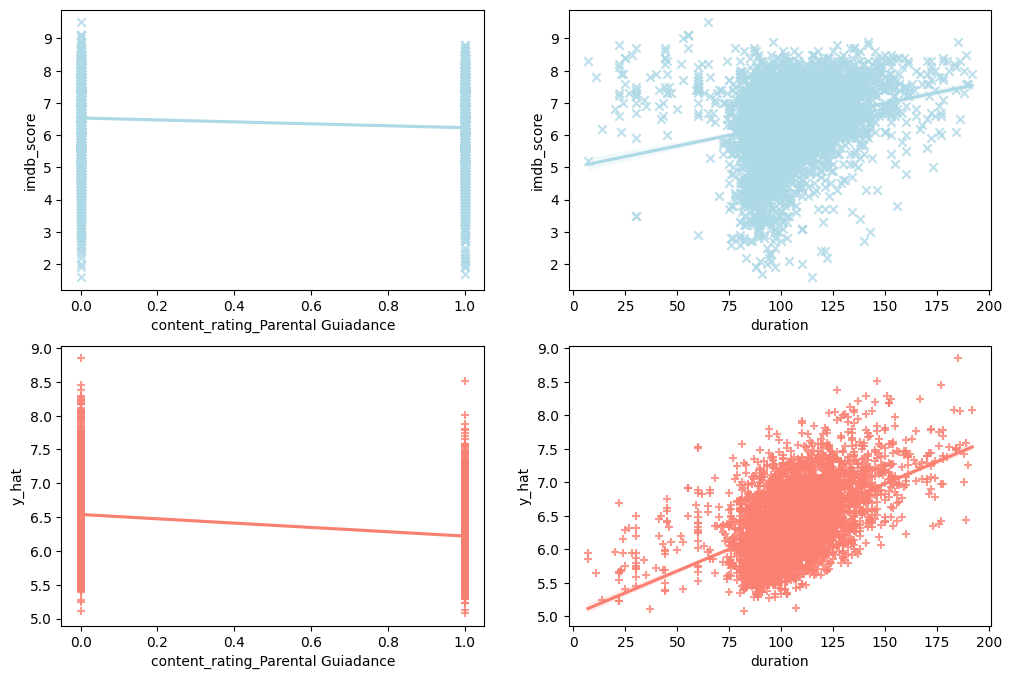

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[1],y=target, data=df , marker='x', color='lightblue')
plt.subplot(2,2,2)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[-6],y=target, data=df , marker='x', color='lightblue')
plt.subplot(2,2,3)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[1],y='y_hat', data=df , marker='+', color='salmon')
plt.subplot(2,2,4)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[-6],y='y_hat', data=df , marker='+', color='salmon')


plt.show()